In [1]:
import pandahouse as ph
import pandas as pd
import numpy as np
import hashlib
from scipy import stats
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pylab

In [2]:
#Подключаемся к базе данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230420',
                      'user':'student', 
                      'password':'dpo_python_2020'}

In [10]:
#Код для разбиения наших юзеров на независимые группы
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [11]:
q = """
SELECT distinct user_id
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-01' and '2023-04-07'
"""

# Вытащили пользователей
users_df = ph.read_clickhouse(q, connection=connection)

# Сделали группы
users_df['hash_group'] = users_df.user_id.apply(ab_split)

# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').user_id.nunique().reset_index()

,hash_group,user_id
0,0,10151
1,1,9982
2,2,9977
3,3,9963
4,4,10076


In [12]:
#Так как в наших данных уже уже есть группы (1,2),
#на которых был реализован новый алгоритм рекомендации постов, выберим необходимые группы сразу, реализуя наш запрос к БД:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-01' and '2023-04-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 
H0 - изменений нет
H1 - CTR увеличится

In [13]:
exp_group_A = df.query("exp_group == 1") #Выбираем из БД группу А с группой 2
exp_group_B = df.query("exp_group == 2") #Выбираем из БД группу B с группой 3

In [14]:
ttest_res = ttest_ind(exp_group_A.ctr, exp_group_B.ctr, equal_var = False) # Проведем TTest

In [15]:
ttest_res #Выведим результат

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Ттест показал p-value 0.47, что говорит нам об отсутствии отличий. Посмотрим график наших групп.

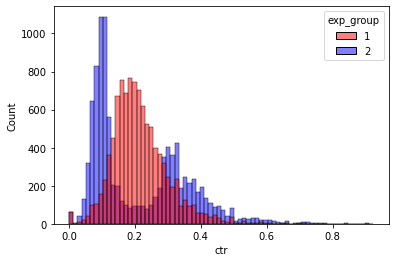

In [16]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Видим очевидные различия. Продолжим исследование и применим другие тесты.

In [19]:
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided'))
print('pvalue < 0.05. Тест подтверждает различия.')
A_gt_B = 0
for _ in range(10000):
    A_gt_B += exp_group_A.ctr.sample().values[0] > exp_group_B.ctr.sample().values[0]
print('B', A_gt_B / 100, '% случаев А > B. Т.е. отличия в выборках у нас есть. Пусть и небольшие.')


MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)
pvalue < 0.05. Тест подтверждает различия.
B 55.92 % случаев А > B. Т.е. отличия в выборках у нас есть. Пусть и небольшие.


Продолжим наше исследование, т.к. результаты по итогам двух тестов противоречивые.

# Сглаживание CTR

In [20]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr # построим функцию для подсчета сглаженного CTR

In [21]:
global_ctr_1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum() #считаем глобальный CTR
global_ctr_2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group == 2].views.sum()

Построим график обычного CTR

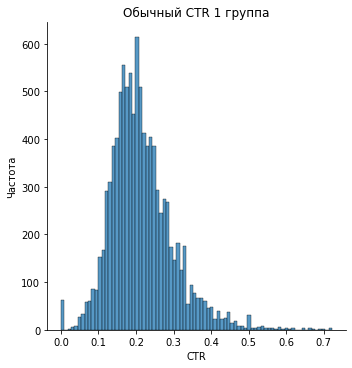

In [22]:
group1 = df[df.exp_group == 1].copy()
sns.displot(group1.ctr, kde = False)
plt.title('Обычный CTR 1 группа')
plt.xlabel('CTR')
plt.ylabel('Частота')
plt.show()



Теперь сглаженный CTR

In [23]:
group1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis = 1) #применим нашу функцию и выберим альфу 5%

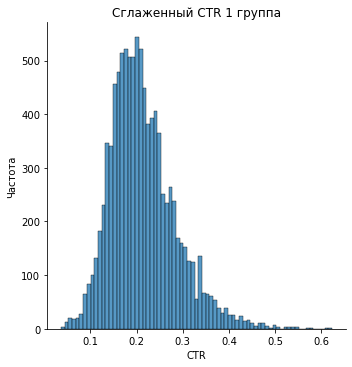

In [24]:
sns.displot(group1.smothed_ctr, kde = False)
plt.title('Сглаженный CTR 1 группа')
plt.xlabel('CTR')
plt.ylabel('Частота')
plt.show()

Повторим проделанные шаги для второй группы

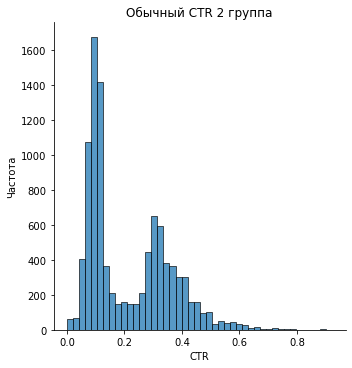

In [25]:
group2 = df[df.exp_group == 2].copy()
sns.displot(group2.ctr, kde = False)
plt.title('Обычный CTR 2 группа')
plt.xlabel('CTR')
plt.ylabel('Частота')
plt.show()



Теперь сглаженный CTR

In [26]:
group2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis = 1) #применим нашу функцию и выберем альфу 5%

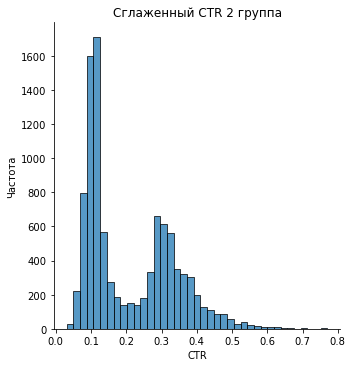

In [27]:
sns.displot(group2.smothed_ctr, kde = False)
plt.title('Сглаженный CTR 2 группа')
plt.xlabel('CTR')
plt.ylabel('Частота')
plt.show()

Итак, построили сглаженный CTR, посмотрели на графики. Уже по графикам видны изменения, особенно в тестовой группе. Давайте посмотрим сглаженный CTR в ttest.

In [28]:
ttest_ind(group1.smothed_ctr, group2.smothed_ctr, equal_var = False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

Видим прокрас по сглаженному CTR (pval < 0.05). Мы отвергаем H0 о том, что наши распределения одинаковые. Данный вывод подкрепляется визуально на графиках.

#### Вернемся к нашему первому графику.

0.20802680490126244 0.1980601844115994


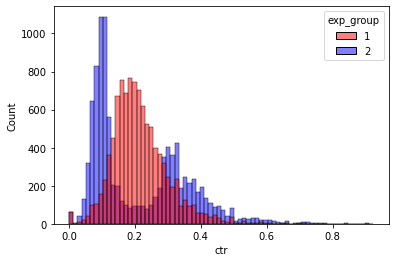

In [29]:
groups = sns.histplot(data = df, 
              x = 'ctr', 
              hue = 'exp_group', 
              palette = ['r', 'b'],
              alpha = 0.5,
              kde = False)
print(global_ctr_1,global_ctr_2)

По графику видно, что группы,очевидно, различные. Но глобальные CTR двух групп почти одинаковый! Вероятнее всего, наши тесты, показывающие отсутствие различий, плохо чувствительны к нашим распределениям.

# Пуассоновский бутстреп

In [30]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap = 2000): #создаем функцию бутстрепа

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1 * likes1).sum(axis = 1) / (poisson_bootstraps1 * views1).sum(axis = 1)
    
    globalCTR2 = (poisson_bootstraps2 * likes2).sum(axis = 1) / (poisson_bootstraps2 * views2).sum(axis = 1)

    return globalCTR1, globalCTR2

In [31]:
likes1 = df[df.exp_group == 1].likes.to_numpy() #выбираем лайки 1 группы 
views1 = df[df.exp_group == 1].views.to_numpy() #выбираем просмотры 1 группы 
likes2 = df[df.exp_group == 2].likes.to_numpy() #выбираем лайки 2 группы 
views2 = df[df.exp_group == 2].views.to_numpy() #выбираем просмотры 2 группы 

In [32]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2) #создаем переменные под наши ctr

<AxesSubplot:ylabel='Count'>

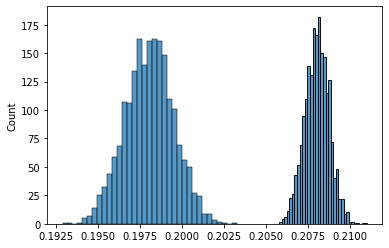

In [33]:
sns.histplot(ctr1) #строим графики
sns.histplot(ctr2)

Итак, по графику видим ухудшения в тестовой группе(справа), что не есть хорошо.

# Распределение разницы CTR

<AxesSubplot:ylabel='Count'>

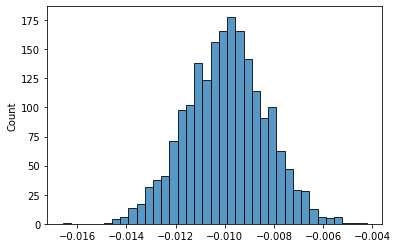

In [34]:
sns.histplot(ctr2 - ctr1)

Распределение лежит слева от нуля, что говорит нам об ухудшении показателей тестовой группы.

# Бакетное преобразование

Зделаем запрос с помощью кликхаус

In [35]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-04-01' and '2023-04-07'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df2 = ph.read_clickhouse(q, connection=connection)

In [36]:
print(stats.mannwhitneyu(df2[df2.exp_group == 1].bucket_ctr, 
                   df2[df2.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided'))
print(stats.ttest_ind(df2[df2.exp_group == 1].bucket_ctr, 
                   df2[df2.exp_group == 2].bucket_ctr, 
                   equal_var = False))

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)
Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)


Тест MU и Ttest показывают маленькое значение, т.е. различия у групп есть. Рисуем бакетное распределение

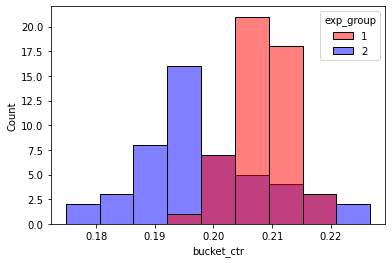

In [37]:
bucketplot = sns.histplot(data = df2, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Очевидные различия.

## ВЫВОД
#### С помощью теста MU поверх бакетов и графиков распределения мы обнаружили, что наши группы различны. Кроме того, наша тестовая группа, на первый взгляд, показала результаты хуже чем в контрольной группе. По графику распределения ctr 1 и 2 групп, мы видим большой акцент распределения влевую сторону, яму в ctr на уровне 0.2, и более высокий хвост справа, т.е. наш алгоритм перераспределил CTR в разные стороны. Сейчас мы не можем говорить о бесполезности нашего нового алгоритма. Необходимо провести дополнительные исследования, посчитать сколько денег мы получаем с новой группы и сделать окончательный вывод о новой фиче. Можно предложить раскать обновление на часть пользователей, не стоит рисковать из-за неочевидных выводов.

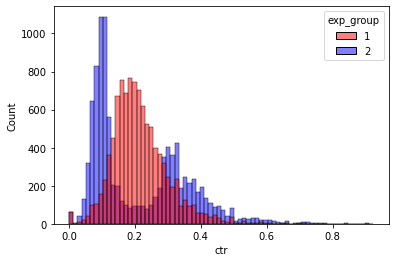

In [38]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)